In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

# Load, scale and normalize the data:
data = np.loadtxt('ex2data1.txt', delimiter=',')
X_initial = data.copy()
X_initial = X_initial[:, 0:2]
X_initial[:, 0] -= X_initial[:, 0].mean()
X_initial[:, 0] /= X_initial[:, 0].std()
X_initial[:, 1] -= X_initial[:, 1].mean()
X_initial[:, 1] /= X_initial[:, 1].std()
y = data[:, 2]

# Feature scaling and regularizing doesn't change the way the data "looks":

## Unscaled:

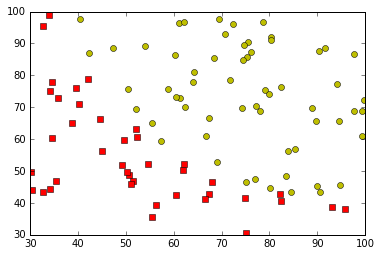

In [35]:
positive = data[data[:, 2] == 1, :]
plt.plot(positive[:, 0], positive[:, 1], 'yo')
negative = data[data[:, 2] == 0, :]
plt.plot(negative[:, 0], negative[:, 1], 'rs')

## Scaled: 

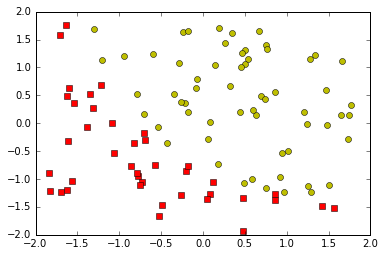

In [37]:
positive = X_initial[y == 1, :]
plt.plot(positive[:, 0], positive[:, 1], 'yo')
negative = X_initial[y == 0, :]
plt.plot(negative[:, 0], negative[:, 1], 'rs')

In [ ]:
def sigmoid(z):
    return 1/(1 + np.power(np.e, -z))

h = lambda theta, x: sigmoid(x.dot(theta))


def cost(theta, X, y, debug=False):
    m = X.shape[0]
    if debug:
        print 'theta: %s' % theta
        print '--'
        print 'X: %s' % X
        print '--'
        print 'y=1: %s  y=0: %s' % ((h(theta, X)), 1 - h(theta, X))
        print 'log probabilities: \ny=1: %s' % np.log(h(theta, X))
        print 'y=0: %s' %  np.log(1 - h(theta, X))
        print '=======\n'

    j = y.dot(np.log(h(theta, X)))  + (1 - y).dot(np.log(1 - h(theta, X)))
    return (-j/m)


def grad(theta, X, y):
    m = X.shape[0]
    return ((h(theta, X) - y).dot(X))/m

# Add a column of ones:
m, features = np.shape(X_initial)
features += 1
X = np.concatenate([np.ones((m, 1)), X_initial], axis=1)
initial_theta = np.zeros((features))


def check_functions(grad_func, cost_func):
    '''
    Asserts that the cost and gradient functions return known corret values for a given theta, X, y.  
    Test case from https://www.coursera.org/learn/machine-learning/discussions/weeks/3/threads/tA3ESpq0EeW70BJZtLVfGQ
    The expected cost is 4.6832.
    The expected gradient = [0.31722, 0.87232, 1.64812, 2.23787]
    '''
    test_X = np.array([[1, 8, 1, 6], [1, 3, 5, 7], [1, 4, 9, 2]])  # X
    test_y = np.array([[1, 0, 1]])  # y
    test_theta = np.array([-2, -1, 1, 2])
    
    grad_diff = grad_func(test_theta, test_X, test_y) - np.array([0.31722, 0.87232, 1.64812, 2.23787])
    assert grad_diff.dot(grad_diff.T) < 0.0001
    assert abs(cost_func(test_theta, test_X, test_y, debug=False) - 4.6832) < 0.0001
    
check_functions(grad, cost)
print minimize(fun=cost, x0=initial_theta, args=(X, y), jac=grad)